In [95]:
import mglearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from darts import TimeSeries
from darts.models import RegressionModel
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

We upload the Citibikes time series:

In [3]:
data = mglearn.datasets.load_citibike()
data.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3h, Name: one, dtype: int64

In [4]:
data.shape

(248,)

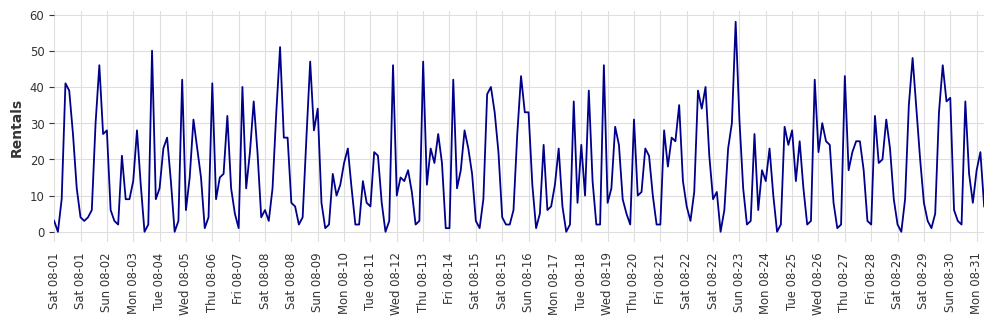

In [5]:
plt.figure(figsize=(12,3))

plt.plot(data.index, data.values, c='darkblue')
plt.xticks(ticks=data.index[::7], labels=data.index[::7].strftime("%a %m-%d"), rotation=90)
plt.ylabel('Rentals')
plt.xlim(min(data.index), max(data.index))
plt.show()

The plot shows some seasonality of number of Rentals

### Predicting with Random Forest

To make a prediction we use 2 features: `hour` and `day of week`

In [6]:
#limit to training set
n = int(data.shape[0] * 0.8)

x1 = data.index.hour.to_numpy().reshape(-1,1)
x2 = data.index.dayofweek.to_numpy().reshape(-1,1)
X = np.c_[x1,x2]
y = data.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

We use the Random Forest Regressor to predict number of rentals for seen and unseen time periods:

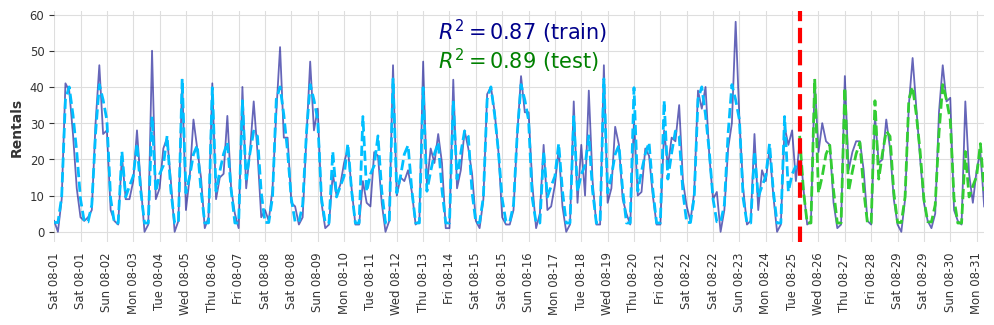

In [7]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=10, max_leaf_nodes=20, random_state=0)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
y_pred_train = rf_reg.predict(X_train)
R2_train = rf_reg.score(X_train, y_train)
R2_test = rf_reg.score(X_test, y_test)

plt.figure(figsize=(12,3))

plt.plot(data.index, data.values, c='darkblue', alpha=0.6)
plt.plot(data.index[n:], y_pred, '--', lw=2, c='limegreen')
plt.plot(data.index[:n], y_pred_train, '--', lw=2, c='deepskyblue')
plt.axvline(x=data.index[n], linestyle='--', c='r', lw=3)

plt.text(x=data.index[102], y=53, s=r'$R^2 = %.2f$ (train)'%R2_train, size=15, c='darkblue')
plt.text(x=data.index[102], y=45, s=r'$R^2 = %.2f$ (test)'%R2_test, size=15, c='green')

plt.xticks(ticks=data.index[::7], labels=data.index[::7].strftime("%a %m-%d"), rotation=90)
plt.ylabel('Rentals')
plt.xlim(min(data.index), max(data.index))
plt.show()

### Predicting with recursive forecasting: DARTS

Using recursive forecasting with `darts`:

In [8]:
df = pd.DataFrame(data).rename(columns={'one':'rentals'})
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df.head()

,rentals,hour,day_of_week
starttime,,,
2015-08-01 00:00:00,3,0,5
2015-08-01 03:00:00,0,3,5
2015-08-01 06:00:00,9,6,5
2015-08-01 09:00:00,41,9,5
2015-08-01 12:00:00,39,12,5


We include an additional window to also show how the model performs in training:

In [81]:
features = ['hour','day_of_week']

df_concat = pd.DataFrame(pd.date_range('2015-09-01 00:00:00', '2015-09-19 09:00:00', freq='3H')).rename(columns={0:'starttime'})
df_concat.index = df_concat['starttime']
df_concat['hour'] = df_concat.index.hour
df_concat['day_of_week'] = df_concat.index.dayofweek
df_concat.drop(columns=['starttime'], inplace=True)

df_future = pd.concat([df[features], df_concat])

In [82]:
#limit to training set
n = int(df.shape[0] * 0.8)
y_rec = TimeSeries.from_series(df['rentals'])

y_train_rec = y_rec[:n]
y_test_rec = y_rec[n:]

future_cov = TimeSeries.from_dataframe(df_future)

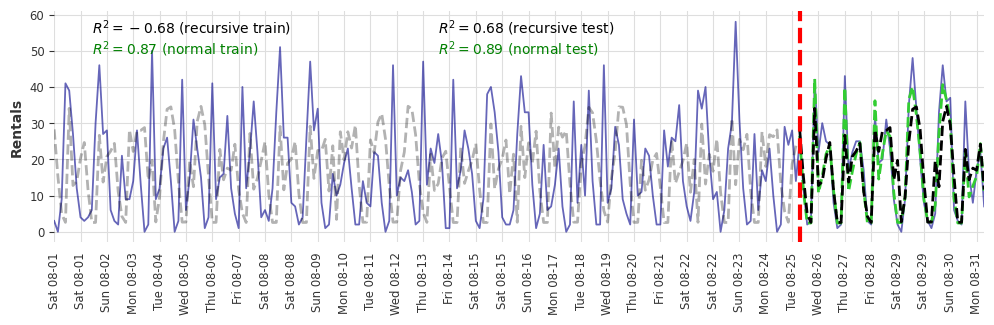

In [94]:
rf_reg_rec = RandomForestRegressor(n_estimators=500, max_depth=10, max_leaf_nodes=20, random_state=0)

model_recursive = RegressionModel(lags=[-1,-2,-3,-4,-5,-6,-12,-24,-48],
                                  model=rf_reg_rec,
                                  lags_future_covariates=[0])

model_recursive.fit(series=y_train_rec, future_covariates=future_cov)

y_pred_train_rec = model_recursive.predict(n=len(y_train_rec), series=y_train_rec).values().ravel()
y_pred_test_rec = model_recursive.predict(n=len(y_test_rec), series=y_train_rec).values().ravel()

R2_test = rf_reg.score(X_test, y_test)
R2_test_rec = r2_score(y_test_rec.values().ravel(), y_pred_test_rec)

R2_train = rf_reg.score(X_train, y_train)
R2_train_rec = r2_score(y_train, y_pred_train_rec)

plt.figure(figsize=(12,3))

plt.plot(data.index, data.values, c='darkblue', alpha=0.6)
plt.plot(data.index[n:], y_pred, '--', lw=2, c='limegreen')
plt.plot(data.index[n:], y_pred_test_rec, '--', lw=2, c='k')
plt.plot(data.index[:n], y_pred_train_rec, '--', lw=2, c='k', alpha=0.3)
plt.axvline(x=data.index[n], linestyle='--', c='r', lw=3)

s = 10
plt.text(x=data.index[102], y=55, s=r'$R^2 = %.2f$ (recursive test)'%R2_test_rec, size=s, c='k')
plt.text(x=data.index[102], y=49, s=r'$R^2 = %.2f$ (normal test)'%R2_test, size=s, c='green')

plt.text(x=data.index[10], y=55, s=r'$R^2 = %.2f$ (recursive train)'%R2_train_rec, size=s, c='k')
plt.text(x=data.index[10], y=49, s=r'$R^2 = %.2f$ (normal train)'%R2_train, size=s, c='green')

plt.xticks(ticks=data.index[::7], labels=data.index[::7].strftime("%a %m-%d"), rotation=90)
plt.ylabel('Rentals')
plt.xlim(min(data.index), max(data.index))
plt.show()